In [100]:
import os
import sys
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses, metrics

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

from _lib import utils
from _lib import metrics


### Constants and hyperparameters

In [101]:
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.1 # Percentage of samples to use for validation
learning_rate = 1e-4 # Learning rate for the optimizer
batch_size = 64 # Number of samples to use for each batch
epochs = 50 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [102]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [103]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # type: ignore

# Add a channel dimension to the images
X_train = np.expand_dims(X_train, axis=-1) # type: ignore
X_test = np.expand_dims(X_test, axis=-1) # type: ignore

# Extract the number of classes in the dataset
num_classes = len(np.unique(y_train)) # type: ignore

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, random_state=seed) # type: ignore

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (54000, 28, 28, 1) (54000,)
Validation set: (6000, 28, 28, 1) (6000,)
Testing set: (10000, 28, 28, 1) (10000,)


### Data preprocessing

In [104]:
# Normalization
def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (np.ndarray): The input data to normalize
    
    Returns:
    - np.ndarray: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [105]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = utils.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = utils.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0])
print("One-hot encoded value:", y_valid_encoded[0])

Sample target value: 8
One-hot encoded value: [0 0 0 0 0 1 0 0 0 0]


### Data visualization

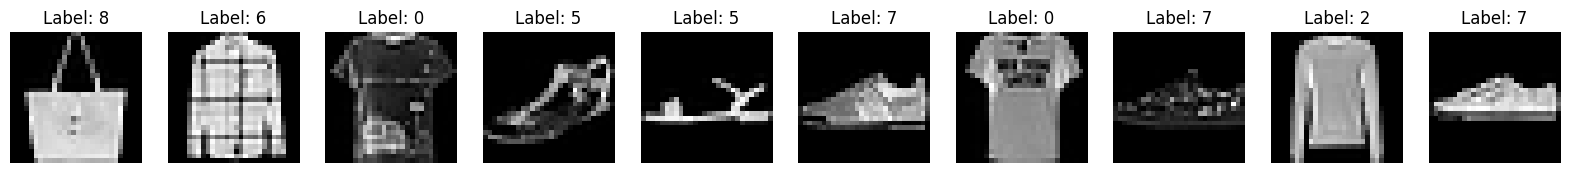

In [106]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
        
# Plot the first 10 samples
plot_samples(list(X_train[:10]), y_train[:10])

### Building the model

In [107]:

model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [108]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=learning_rate), 
    loss = losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [109]:
# Display the model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,186 (1.66 MB)

 Trainable params: 427,914 (1.63 MB)

 Non-trainable params: 6,272 (24.50 KB)

### Training the model

In [110]:
history = model.fit(
    X_train,
    y_train_encoded,
    validation_data = (X_valid, y_valid_encoded),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6800 - loss: 0.9026 - val_accuracy: 0.8460 - val_loss: 0.4237
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8536 - loss: 0.4033 - val_accuracy: 0.8647 - val_loss: 0.3693
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8765 - loss: 0.3419 - val_accuracy: 0.8867 - val_loss: 0.3089
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8913 - loss: 0.2991 - val_accuracy: 0.8987 - val_loss: 0.2816
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9023 - loss: 0.2743 - val_accuracy: 0.9003 - val_loss: 0.2657
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9031 - loss: 0.2594 - val_accuracy: 0.9095 - val_loss: 0.2471
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9107 - loss: 0.2447 - val_accuracy: 0.9127 - val_loss: 0.2445
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9181 - loss: 0.2231 - 

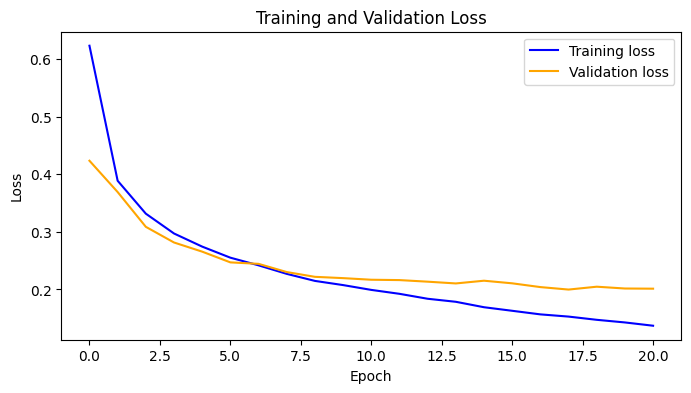

In [111]:
# Plot the training and validation loss
utils.plot_history(history.history['loss'], history.history['val_loss'], "Training and Validation Loss", "Epoch", "Loss")

### Model evaluation

In [112]:
# Predict the labels
predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = np.argmax(predictions, axis=1)

Accuracy: 0.93


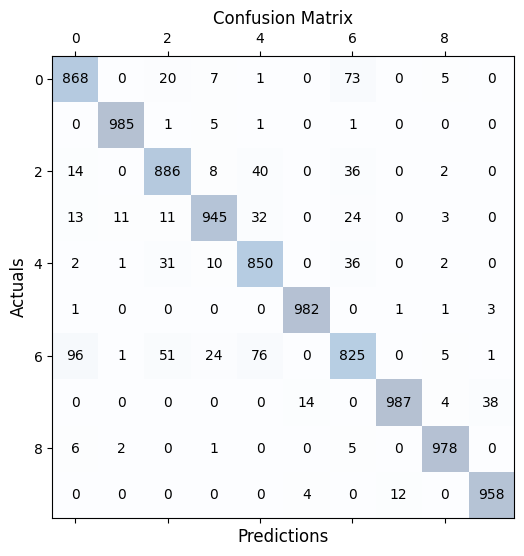

In [113]:
# Compute the accuracy
accuracy = metrics.accuracy(predictions, y_test)
confusion_matrix = metrics.confusion_matrix(num_classes, predictions, y_test)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
utils.plot_confusion_matrix(confusion_matrix)